## 📦 Importing Libraries

We import the core libraries required for this project:

- `numpy`, `pandas`, and `matplotlib.pyplot` for data manipulation and visualization.
- `torch`, `torch.nn`, and `torch.utils.data` for building and training deep learning models.
- `transformers` from Hugging Face for using the pretrained BERT model and tokenizer.
- `sklearn.metrics.r2_score` for evaluating model performance.
- `tqdm` for tracking training progress.
- `torch.optim` and `ReduceLROnPlateau` for model optimization and learning rate scheduling.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import r2_score
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

## 📰 Loading and Preprocessing News Data

We load the news dataset from a CSV file, skipping the header row and assigning column names `Date` and `News`. The following preprocessing steps are applied:

- **Datetime conversion**: Convert the `Date` string to a proper datetime object.
- **Data cleaning**: Remove any rows with invalid or missing datetime values.
- **Feature extraction**: Extract the date and hour from the datetime.
- **Market tagging**: Add a binary feature `PreMarket` which indicates whether the news was published before 9:00 AM (1 for pre-market, 0 otherwise).

In [ ]:
# Read CSV and skip header
news = pd.read_csv("/content/train_news.csv", skiprows=1, header=None, names=["Date", "News"])

# Convert to datetime
news['Datetime'] = pd.to_datetime(news['Date'], errors='coerce')  # safer parsing

# Drop rows where conversion failed
news = news.dropna(subset=['Datetime'])

# Extract date and hour
news['Date'] = news['Datetime'].dt.date
news['Hour'] = news['Datetime'].dt.hour

# Add PreMarket tag
news['PreMarket'] = (news['Hour'] < 9).astype(int)

In [ ]:
def tag_news(row):
    tag = "[PREMARKET]" if row['PreMarket'] else "[POSTMARKET]"
    return f"{tag} {row['News']}"

news['TaggedNews'] = news.apply(tag_news, axis=1)

In [ ]:
news

,Date,News,Datetime,Hour,PreMarket,TaggedNews
0,2007-01-09,"DIARY - Belgium to Jan 31, 2006",2007-01-09 05:00:00,5,1,"[PREMARKET] DIARY - Belgium to Jan 31, 2006"
1,2007-01-09,Japan's defense agency upgraded to ministry,2007-01-09 05:03:00,5,1,[PREMARKET] Japan's defense agency upgraded to...
2,2007-01-09,General Electric seeks bids for plastics unit ...,2007-01-09 05:10:00,5,1,[PREMARKET] General Electric seeks bids for pl...
3,2007-01-09,NY gas smell sends 19 to hospital,2007-01-09 05:11:00,5,1,[PREMARKET] NY gas smell sends 19 to hospital
4,2007-01-09,Fish follow their noses back to tropical reefs,2007-01-09 05:18:00,5,1,[PREMARKET] Fish follow their noses back to tr...
...,...,...,...,...,...,...
841847,2014-09-10,UPDATE 3-Soft bounce in Japan machinery orders...,2014-09-10 23:47:00,23,0,[POSTMARKET] UPDATE 3-Soft bounce in Japan mac...
841848,2014-09-10,INDIA PRESS-K.K. Modi Group to consolidate all...,2014-09-10 23:52:00,23,0,[POSTMARKET] INDIA PRESS-K.K. Modi Group to co...
841849,2014-09-10,One big inning helps Twins win,2014-09-10 23:52:00,23,0,[POSTMARKET] One big inning helps Twins win
841850,2014-09-10,Soft bounce in Japan machinery orders leaves d...,2014-09-10 23:55:00,23,0,[POSTMARKET] Soft bounce in Japan machinery or...


## 🗞️ Grouping News Headlines by Date

Since multiple news headlines can be published on the same date, we group them together:

- We use `groupby` on the `Date` column and concatenate all `TaggedNews` entries from the same day into a single string.
- This aggregation ensures that each date is associated with a unified textual representation of all related headlines, which is essential for combining with time series data later.

In [ ]:
# Grouper les headlines (si plusieurs pour la même journée)
grouped_news = news.groupby('Date')['TaggedNews'].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
grouped_news

,Date,TaggedNews
0,2007-01-09,"[PREMARKET] DIARY - Belgium to Jan 31, 2006 [P..."
1,2007-01-10,[PREMARKET] On the radar: PPG [PREMARKET] UPD...
2,2007-01-21,[PREMARKET] Serbians vote in close-run electio...
3,2007-01-22,[PREMARKET] Rwanda at risk of more ethnic viol...
4,2007-01-23,[PREMARKET] U.S. hotel revenue expected to kee...
...,...,...
418,2014-08-16,[PREMARKET] Vestiage Announces Increase in Dir...
419,2014-08-17,[PREMARKET] U.S. Census Bureau Daily Feature f...
420,2014-08-28,[PREMARKET] AT&T; 4G LTE Available In Harrison...
421,2014-09-04,[PREMARKET] IEX Group raises $75 million in pu...


## 💰 Merging Price and News Data

We load the stock price dataset and merge it with the grouped news headlines:

- **Loading**: The `train_prices.csv` file is read into a DataFrame.
- **Date formatting**: Convert the `Date` column to a standard date format (excluding time).
- **Merging**: Combine the stock prices with the corresponding daily news using a left join on the `Date` column.
- **Missing values**: Any missing news entries are filled with empty strings to ensure compatibility with the tokenizer.

In [ ]:
prices = pd.read_csv("/content/train_prices.csv")
prices['Date'] = pd.to_datetime(prices['Date']).dt.date

merged = pd.merge(prices, grouped_news, on='Date', how='left').fillna("")

In [ ]:
merged

,Date,price1,price2,price3,TaggedNews
0,2007-01-09,14.401353,6.80,19.754984,"[PREMARKET] DIARY - Belgium to Jan 31, 2006 [P..."
1,2007-01-10,14.477186,6.73,19.529560,[PREMARKET] On the radar: PPG [PREMARKET] UPD...
2,2007-01-11,14.515105,6.81,20.026424,
3,2007-01-12,14.408934,7.06,20.399076,
4,2007-01-16,14.408934,6.91,20.468081,
...,...,...,...,...,...
1929,2014-09-08,63.971821,8.50,41.135307,
1930,2014-09-09,63.341549,8.49,40.896870,
1931,2014-09-10,63.446613,8.54,40.763348,[PREMARKET] Nationwide Credit Bureaus Launch N...
1932,2014-09-11,62.991421,8.51,41.125763,


## ⏮️ Creating Lag Features for Time Series

We define a function `create_lags` to generate lagged features from the stock price data:

- **Lag generation**: For each price column (e.g., `price1`, `price2`, `price3`), we create lag features for the past `n` days (in this case, 7).
- **Missing values**: Rows with `NaN` values introduced by the lagging process are removed to ensure clean input for modeling.
- **Output**: The resulting dataset `merged_lags` includes original prices, lagged features, and associated daily news.

In [ ]:
def create_lags(df, lag_days, price_cols=['price1', 'price2', 'price3']):
    df_lag = df.copy()
    for col in price_cols:
        for lag in range(1, lag_days + 1):
            df_lag[f'{col}_lag{lag}'] = df_lag[col].shift(lag)
    # Supprimer les lignes avec NaN dus aux lags
    df_lag = df_lag.dropna().reset_index(drop=True)
    return df_lag

merged_lags = create_lags(merged, lag_days=7)

In [ ]:
merged_lags

,Date,price1,price2,price3,TaggedNews,price1_lag1,price1_lag2,price1_lag3,price1_lag4,price1_lag5,...,price2_lag5,price2_lag6,price2_lag7,price3_lag1,price3_lag2,price3_lag3,price3_lag4,price3_lag5,price3_lag6,price3_lag7
0,2007-01-19,13.915998,6.88,20.702705,,14.158678,14.158678,14.408934,14.408934,14.515105,...,6.81,6.73,6.80,20.362261,20.500284,20.468081,20.399076,20.026424,19.529560,19.754984
1,2007-01-22,14.029755,6.90,20.472672,[PREMARKET] Rwanda at risk of more ethnic viol...,13.915998,14.158678,14.158678,14.408934,14.408934,...,7.06,6.81,6.73,20.702705,20.362261,20.500284,20.468081,20.399076,20.026424,19.529560
2,2007-01-23,14.029755,6.92,20.601494,[PREMARKET] U.S. hotel revenue expected to kee...,14.029755,13.915998,14.158678,14.158678,14.408934,...,6.91,7.06,6.81,20.472672,20.702705,20.362261,20.500284,20.468081,20.399076,20.026424
3,2007-01-24,14.029755,6.89,20.656698,[PREMARKET] On the defense [PREMARKET] UPDATE ...,14.029755,14.029755,13.915998,14.158678,14.158678,...,6.83,6.91,7.06,20.601494,20.472672,20.702705,20.362261,20.500284,20.468081,20.399076
4,2007-01-25,14.113171,6.75,20.100031,,14.029755,14.029755,14.029755,13.915998,14.158678,...,6.77,6.83,6.91,20.656698,20.601494,20.472672,20.702705,20.362261,20.500284,20.468081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922,2014-09-08,63.971821,8.50,41.135307,,63.682964,63.910568,63.831764,63.849262,63.201492,...,8.60,8.49,8.54,40.963638,41.125763,41.822010,42.193970,42.327496,42.346581,42.670853
1923,2014-09-09,63.341549,8.49,40.896870,,63.971821,63.682964,63.910568,63.831764,63.849262,...,8.63,8.60,8.49,41.135307,40.963638,41.125763,41.822010,42.193970,42.327496,42.346581
1924,2014-09-10,63.446613,8.54,40.763348,[PREMARKET] Nationwide Credit Bureaus Launch N...,63.341549,63.971821,63.682964,63.910568,63.831764,...,8.56,8.63,8.60,40.896870,41.135307,40.963638,41.125763,41.822010,42.193970,42.327496
1925,2014-09-11,62.991421,8.51,41.125763,,63.446613,63.341549,63.971821,63.682964,63.910568,...,8.49,8.56,8.63,40.763348,40.896870,41.135307,40.963638,41.125763,41.822010,42.193970


## 🧠 Multimodal Neural Network Architecture

We define the `MultimodalTask` class, a PyTorch neural network that fuses time series data with textual BERT embeddings to predict multiple stock prices:

- **BERT module**: Loads a pretrained `bert-base-uncased` model. Only the top layers are fine-tuned; the lower layers are frozen to reduce training time.
- **Time series embedding**: Projects the lagged numerical inputs to the same dimensional space as BERT embeddings (`d_model = 768`).
- **Transformer encoders**: Light Transformer layers process both time series and textual features independently.
- **Feature pooling**: Mean pooling is applied across the sequence dimension to obtain fixed-size representations.
- **Fusion & prediction**: The pooled text and time series features are added together, and passed through a feedforward network (`price_head`) to output predictions for three price targets.

In [ ]:
class MultimodalTask(nn.Module):
    def __init__(self, ts_input_dim=3, d_model=768, seq_len=3, num_heads=4, dropout=0.2):
        super().__init__()

        self.bert = BertModel.from_pretrained("bert-base-uncased")
        for name, param in self.bert.named_parameters():
            if "encoder.layer.0" in name or "encoder.layer.1" in name:
                param.requires_grad = False
        else:
            param.requires_grad = True

        self.ts_embedding = nn.Sequential(
            nn.Linear(ts_input_dim, d_model//2),
            nn.LayerNorm(d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=4*d_model,
            dropout=dropout,
            batch_first=True
        )
        self.ts_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.text_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)

        self.price_head = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.LayerNorm(d_model//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, 3)
        )

    def forward(self, ts_input, text_input_ids, attention_mask):
        ts_emb = self.ts_embedding(ts_input)
        ts_encoded = self.ts_encoder(ts_emb)

        with torch.no_grad():
            bert_output = self.bert(input_ids=text_input_ids, attention_mask=attention_mask)
            text_features = bert_output.last_hidden_state

        text_pooled = text_features.mean(dim=1)
        ts_pooled = ts_encoded.mean(dim=1)

        fused = ts_pooled + text_pooled
        prices = self.price_head(fused)
        return prices

## 📚 Dataset Class and DataLoader Preparation

We define a custom PyTorch `Dataset` and a helper function for creating DataLoaders:

### `MarketDataset`:
- **Inputs**: Receives the full DataFrame, BERT tokenizer, and number of lag days.
- **Time series features**: Constructs a sequence of lagged prices for each sample, forming `[seq_len, 3]` time series input.
- **Text features**: Tokenizes the `TaggedNews` field using the BERT tokenizer with padding and truncation.
- **Targets**: Extracts the actual stock prices (`price1`, `price2`, `price3`) as prediction targets.

### `prepare_datasets`:
- Splits the data into training and validation sets (default 80/20 split).
- Instantiates `MarketDataset` for both sets.
- Returns PyTorch DataLoaders for training and validation, either as a dictionary (for flexibility) or a single DataLoader.

In [ ]:
class MarketDataset(Dataset):
    def __init__(self, df, tokenizer, lag_days=7):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.lag_days = lag_days
        self.price_cols = ['price1', 'price2', 'price3']

        # Préparer TS features avec lags
        self.ts_features = []
        for _, row in df.iterrows():
            lag_values = []
            for lag in range(1, lag_days+1):
                lag_values.append([row[f'price1_lag{lag}'], row[f'price2_lag{lag}'], row[f'price3_lag{lag}']])
            self.ts_features.append(lag_values)

        # Cibles prix
        self.price_targets = df[self.price_cols].values.astype(float)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        ts = torch.tensor(self.ts_features[idx], dtype=torch.float32)  # [seq_len, features]
        news_text = self.df.loc[idx, 'TaggedNews']

        # Tokenizer
        text_tokens = self.tokenizer(
            news_text,
            padding='max_length',
            truncation=True,
            max_length=64,
            return_tensors='pt'
        )

        prices = torch.tensor(self.price_targets[idx], dtype=torch.float32)

        return ts, text_tokens['input_ids'].squeeze(0), text_tokens['attention_mask'].squeeze(0), prices

In [ ]:
# 3. Update the prepare_datasets function to return either a single DataLoader or a dictionary
def prepare_datasets(merged_lags, tokenizer, val_size=0.2, return_dict=False):
    # Split into train/val
    train_df = merged_lags.iloc[:int(len(merged_lags)*(1-val_size))]
    val_df = merged_lags.iloc[int(len(merged_lags)*(val_size)):]

    # Create datasets
    train_dataset = MarketDataset(train_df, tokenizer)
    val_dataset = MarketDataset(val_df, tokenizer)

    if return_dict:
        # Return as dictionary (for train_model that expects dict)
        return {
            'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
            'val': DataLoader(val_dataset, batch_size=32, shuffle=False)
        }
    else:
        # Return single DataLoader (for simpler cases)
        return DataLoader(train_dataset, batch_size=32, shuffle=True)

## 📏 Evaluation Metrics and Model Assessment

We define functions to evaluate the performance of our multimodal model using the R² score:

### `calculate_r2`:
- Computes the **R² score** (coefficient of determination) **individually for each of the three predicted price variables**.
- Returns both the **mean R² score** and a list of per-target scores.

### `evaluate_model`:
- Sets the model to evaluation mode and disables gradient computation.
- Iterates over the validation DataLoader to collect predictions and true values.
- Uses the `calculate_r2` function to compute the average and per-target R² scores.
- Returns the results for downstream analysis and visualization.

In [ ]:
# 1. Evaluation Metrics
def calculate_r2(y_true, y_pred):
    """Calculate R² score for each target variable"""
    r2_scores = []
    for i in range(y_true.shape[1]):
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        r2_scores.append(r2)
    return np.mean(r2_scores), r2_scores

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for ts, input_ids, attention_mask, prices_true in dataloader:
            ts = ts.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            prices_pred = model(ts, input_ids, attention_mask)

            all_preds.append(prices_pred.cpu().numpy())
            all_targets.append(prices_true.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    r2_mean, r2_scores = calculate_r2(all_targets, all_preds)
    return r2_mean, all_preds, all_targets

## 🏋️ Model Training Loop

This function handles the training and optional validation of the multimodal model:

- **Loss function**: We use Mean Squared Error (MSE) as the training loss.
- **Training logic**:
  - The model is trained for a defined number of epochs.
  - For each batch, time series and tokenized news are passed through the model.
  - Gradients are computed via backpropagation and used to update the model parameters.
- **Validation logic**:
  - If a validation loader is provided, the model is evaluated after each epoch using the R² score.
  - The best-performing model (highest validation R²) is saved.
- **Learning rate scheduler**: Adjusts the learning rate based on validation loss to improve convergence.
- **Logging**: Training loss and validation R² are stored in a history dictionary for visualization and analysis.

In [ ]:
def train_model(model, dataloader, optimizer, device, num_epochs=10, is_dict=False):
    mse_loss_fn = nn.MSELoss()
    history = {'train_loss': [], 'val_r2': []}

    best_r2 = -np.inf

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        # Handle both single DataLoader and dictionary cases
        if is_dict:
            train_loader = dataloader['train']
            val_loader = dataloader['val']
        else:
            train_loader = dataloader
            val_loader = None  # No validation in this case

        # Training phase
        for ts, input_ids, attention_mask, prices_true in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            ts = ts.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            prices_true = prices_true.to(device)

            optimizer.zero_grad()
            prices_pred = model.forward(ts, input_ids, attention_mask)

            loss = mse_loss_fn(prices_pred, prices_true)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_loss)
        scheduler.step(avg_loss)  # avg_loss vient de ton calcul

        # Validation phase if available
        if val_loader is not None:
            val_r2, all_preds, all_targets = evaluate_model(model, val_loader, device)
            history['val_r2'].append(val_r2)
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Val R²: {val_r2:.4f}")

            # Save best model
            if val_r2 > best_r2:
                best_r2 = val_r2
                torch.save(model.state_dict(), 'best_model.pth')
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

    return model, history, all_preds

## ⚙️ Model Initialization and Optimization Setup

We set up the model components and training configuration:

- **Tokenizer**: Load the `bert-base-uncased` tokenizer from Hugging Face to preprocess news text.
- **Device setup**: Use GPU (`cuda`) if available, otherwise fall back to CPU.
- **Model instantiation**: Initialize the `MultimodalTask` model and move it to the selected device.
- **Optimizer**: Use the Adam optimizer with a learning rate of `1e-3` to update model parameters.
- **Scheduler**: Apply `ReduceLROnPlateau` to reduce the learning rate if the validation loss plateaus, which helps improve model convergence.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultimodalTask().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## 🚀 Dataset Preparation and Model Training Execution

We now prepare the data and launch the training process:

- **`prepare_datasets`**: Splits the dataset into training and validation sets, returning them as DataLoaders in a dictionary format.
- **Training**: Call `train_model()` using the multimodal model, optimizer, and prepared DataLoaders.
- The model is trained across multiple epochs, and training loss and validation R² are tracked in the `history` object.
- **Predictions**: At the end of training, the model outputs predictions on the validation set.

In [ ]:
dataloader_dict = prepare_datasets(merged_lags, tokenizer, return_dict=True)
trained_model, history, predictions = train_model(model, dataloader_dict, optimizer, device, is_dict=True)

Epoch 1: 100%|██████████| 49/49 [08:11<00:00, 10.02s/it]


Epoch 1/10 - Loss: 280.5838 - Val R²: -1.6670


Epoch 2: 100%|██████████| 49/49 [08:05<00:00,  9.90s/it]


Epoch 2/10 - Loss: 133.4467 - Val R²: -0.6072


Epoch 3: 100%|██████████| 49/49 [08:01<00:00,  9.82s/it]


Epoch 3/10 - Loss: 95.7396 - Val R²: -0.3104


Epoch 4: 100%|██████████| 49/49 [08:02<00:00,  9.85s/it]


Epoch 4/10 - Loss: 91.7140 - Val R²: -0.2447


Epoch 5: 100%|██████████| 49/49 [08:05<00:00,  9.91s/it]


Epoch 5/10 - Loss: 46.7782 - Val R²: 0.1063


Epoch 6: 100%|██████████| 49/49 [08:06<00:00,  9.92s/it]


Epoch 6/10 - Loss: 23.2361 - Val R²: 0.2457


Epoch 7: 100%|██████████| 49/49 [08:07<00:00,  9.95s/it]


Epoch 7/10 - Loss: 12.3612 - Val R²: 0.2657


Epoch 8: 100%|██████████| 49/49 [08:07<00:00,  9.95s/it]


Epoch 8/10 - Loss: 8.4176 - Val R²: 0.3918


Epoch 9: 100%|██████████| 49/49 [08:06<00:00,  9.93s/it]


Epoch 9/10 - Loss: 6.8398 - Val R²: 0.3717


Epoch 10: 100%|██████████| 49/49 [08:09<00:00,  9.99s/it]


Epoch 10/10 - Loss: 6.2764 - Val R²: 0.3329


## 📊 Visualizing Training Performance

We plot the model's training progress across epochs:

- **Training Loss**: Shows how the mean squared error decreases during training, helping us assess model fit and convergence.
- **Validation R²**: Tracks the coefficient of determination (R² score) on the validation set, indicating how well the model explains variance in the target prices.
- These plots help diagnose overfitting, underfitting, and the overall learning dynamics of the model.

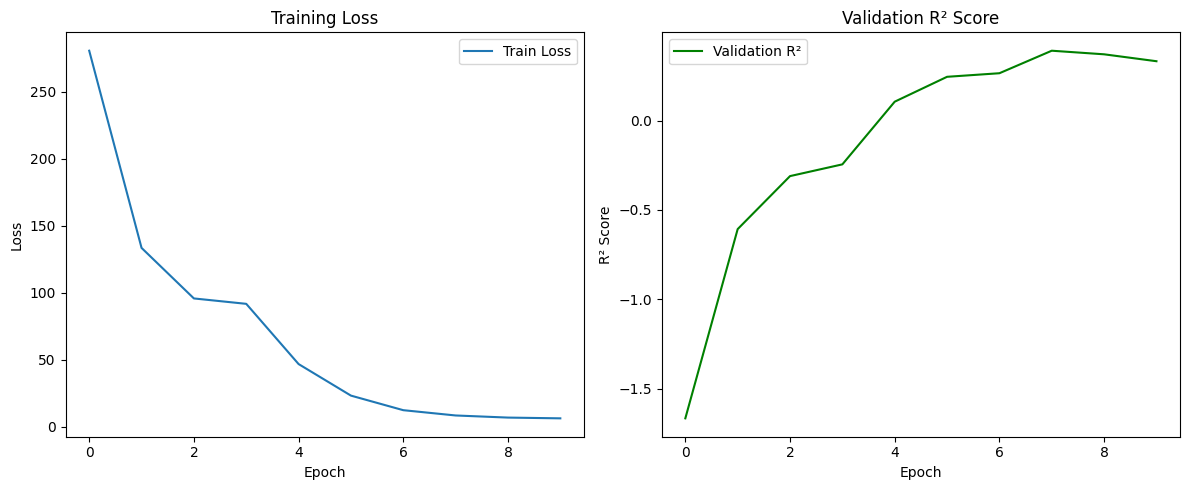

In [ ]:
# Plot training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot validation R²
plt.subplot(1, 2, 2)
plt.plot(history['val_r2'], label='Validation R²', color='green')
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("Validation R² Score")
plt.legend()

plt.tight_layout()
plt.show()